#  Scania Trucks Predictive Maintenance

## Machine Learning
---
### Lilit Petrosyan

![](banner_scania.jpg)

Support Vector Machine | Confusion Matrix | Cutoff | Principal Component Analysis | Balancing

In [1]:
f = "setup.R"; for (i in 1:10) { if (file.exists(f)) break else f = paste0("../", f) }; source(f)

.................................................... start of document ....................................................

## Situation

This application of business analytics is an example of "predictive maintenance", leveraging industrial internet of things (IIOT) technology.

**Role, Decision, Approach, & Data:**
* **Role:** Vice President of Fleet Operations.
* **Decision:** When to call in trucks for APS maintenance?
* **Approach:** Build various models to predict imminent APS failures, using **one** predictive analytic method (support vector machine with specific hyper-parameter settings), **one** data preparation/representation, and **several** cutoffs.  Then use the models to plan APS maintenance given new measurements.  For each model, calculate and compare the costs of unnecessary maintenance and neglected maintenance.
* **Dataset:** These datasets are part of the APS Failure and Operational Data for Scania Trucks, provided by UCI ML Repository. The datasets comprise maintenance records and measurements collected from sensors on heavy Scania trucks in everyday usage.  Specifically, the maintenance records address failures in the trucks' Air Pressure System (APS), which generates pressurized air utilized in various functions, such as braking and gear changes. The datasets' positive class indicates trucks with failures for a specific component of the APS system. The negative class indicates trucks with failures for components not related to the APS.  The larger dataset contains 60000 observations of which 59000 belong to the negative class and 1000 to the positive class.   The smaller dataset contains new 16000 observations. There are 170 measurements per observation.  Missing values are denoted by "na".

**About this Version of the Analysis:**
For pedagogical purposes, this version of the analysis builds models based on 5000 of the 60000 observations avaiable.

## Decision Model

### Influence Diagram

<img src="business-model_scania.jpg" align=left width=750 />

### Business Parameters

Assume that bringing in a truck for maintenance costs $100 if it does not need maintenance.

Assume that repairing a failed truck on the road costs $5000 if the failure could have been prevented by bringing the truck in for maintenance.

In [2]:
pop.ok = 59000
pop.failure = 1000

cost.unnecessary_check = 100
cost.missed_failure = 5000

data.frame(pop.ok, pop.failure, cost.unnecessary_check, cost.missed_failure)

pop.ok,pop.failure,cost.unnecessary_check,cost.missed_failure
59000,1000,100,5000


## Data

Retrieve the raw data.  This is `data.raw`.

In [3]:
data = read.csv("Scania-5000.csv", na.strings="na")
layout(size(data), data.frame(table(data$class, dnn="class")))
head(data)

observations,variables
5000,171
class,Freq
neg,4916
pos,84


class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,...,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
neg,76698,NA,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,...,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.80,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
neg,33058,NA,0,NA,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,...,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
neg,41040,NA,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,...,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
neg,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,...,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
neg,60874,NA,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,...,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0
neg,38312,NA,2130706432,218,0,0,0,0,0,0,9128,701702,1462836,449716,39000,660,1087760,0,0,0,0,0,2283060,1892752,469244,347054,0,0,0,0,1142,452,0,0,0,0,...,44,0,0,0,0,0,0,0,0,21304,73432,16092,0,0,52748,12092,10244700,1126020,0,0,0,0,0,1013.14,1100,301078,481542,388574,288278,900430,300412,1534,338,856,0,0,0


For convenience, rename class values.

In [4]:
data$class = factor(data$class, levels=c("pos","neg"), labels=c("failure","ok"))
layout(size(data), data.frame(table(data$class, dnn="class")))
head(data)

observations,variables
5000,171
class,Freq
failure,84
ok,4916


class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,...,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
ok,76698,NA,2130706438,280,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,...,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.80,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
ok,33058,NA,0,NA,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,...,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
ok,41040,NA,228,100,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,...,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
ok,12,0,70,66,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,...,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
ok,60874,NA,1368,458,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,...,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0
ok,38312,NA,2130706432,218,0,0,0,0,0,0,9128,701702,1462836,449716,39000,660,1087760,0,0,0,0,0,2283060,1892752,469244,347054,0,0,0,0,1142,452,0,0,0,0,...,44,0,0,0,0,0,0,0,0,21304,73432,16092,0,0,52748,12092,10244700,1126020,0,0,0,0,0,1013.14,1100,301078,481542,388574,288278,900430,300412,1534,338,856,0,0,0


### Baseline

In [5]:
# count.unnecessary_check =  (cm["failure","ok"] / sum(cm[,"ok"])) * length(which(data.new.1$class=="ok"))
# count.missed_failure = (cm["ok","failure"] / sum(cm[,"failure"])) * length(which(data.new.1$class=="failure"))
# cost = cost.unnecessary_check*count.unnecessary_check + cost.missed_failure*count.missed_failure


## Analysis I

### Model 1

#### Prepare Data

Keep only observations with no missing values.

In [6]:
data.complete = data[complete.cases(data),]
layout(size(data.complete), data.frame(table(data.complete$class, dnn="class")))
fmt(head(data.complete))

observations,variables
52,171
class,Freq
failure,8
ok,44


class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,ay_004,ay_005,ay_006,ay_007,ay_008,ay_009,az_000,az_001,az_002,az_003,az_004,az_005,az_006,az_007,az_008,az_009,ba_000,ba_001,ba_002,ba_003,ba_004,ba_005,ba_006,ba_007,ba_008,ba_009,bb_000,bc_000,bd_000,be_000,bf_000,bg_000,bh_000,bi_000,bj_000,bk_000,bl_000,bm_000,bn_000,bo_000,bp_000,bq_000,br_000,bs_000,bt_000,bu_000,bv_000,bx_000,by_000,bz_000,ca_000,cb_000,cc_000,cd_000,ce_000,cf_000,cg_000,ch_000,ci_000,cj_000,ck_000,cl_000,cm_000,cn_000,cn_001,cn_002,cn_003,cn_004,cn_005,cn_006,cn_007,cn_008,cn_009,co_000,cp_000,cq_000,cr_000,cs_000,cs_001,cs_002,cs_003,cs_004,cs_005,cs_006,cs_007,cs_008,cs_009,ct_000,cu_000,cv_000,cx_000,cy_000,cz_000,da_000,db_000,dc_000,dd_000,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
ok,31300,0,784,740,0,0,0,0,0,20386,847078,2404100,2645236,2415620,1957818,459032,4730560,0,0,0,38582,60878,10050600,9473796,2022538,530234,0,0,0,0,1736,1164,0,0,0,0,0,0,0,1958836,8790434,0,10364,2952,3596,1435896,1136152,7914616,234256,11438,0,0,6776298,2165810,659492,404564,322062,230824,116654,64192,9168,206,12111862,254,226,444,0,4730560,293792,349952,1671484,193360,186560,185780,189300,196400,200560,196340,196580,720,31300.82,12111862,12111862,12093948,19275,6256,118688,7220,10753880,1209600,1012604,62,586,0,5222058,3987438.72,1525939.2,4,1368,0,19236,518128,1997044,3112882,2766802,2052512,279284,3304,78,214,1100,12111862,0,12398,1510,61822,2829888,1358728,5264506,1185462,34954,2,0,688,1628,4865556,28858,0,5196,0,0,5444212,27758,4492,0,0,32230,4162482,0,0,0,0,82844,352,84,7345640,1436010,425200,113400,12920,9218,11752100,4112,0,0,0,4923.88,3018,5895398,3849254,798872,112724,51736,7054,6628,27600,2,2,0,0
ok,97000,0,378,160,0,0,0,0,0,84938,2172716,4818644,3113846,523016,14590,0,4706546,0,0,0,34126,50964,9612370,8765116,1432862,695194,0,0,0,0,380,530,0,0,0,0,0,0,1398452,9185576,143722,0,14274,1568,2404,2976,19180,8465634,2192568,28644,502,0,6770220,1773144,948234,392148,245140,193264,153696,108774,66214,76916,11080752,812,118,8234,0,4706546,115040,401350,1029202,178560,140640,143720,152740,156080,170420,143560,138300,28060,97000.63,11080752,11080752,11350370,33123,114,3616,177560,10733254,1209600,403228,0,430,0,6374865,2717504.64,1631131.2,680,1458,0,2624,437316,1563610,3884236,3119898,1174734,433042,107926,4364,2496,2888,11080752,0,16580,2344,3598252,897714,685356,4466168,986700,74082,554,0,242,598,6320368,833382,0,3164,0,0,6503272,15580,2636,0,0,5660,3173544,0,0,0,0,37806,17372,2590,7053478,2661512,297314,98366,15240,2444,2533098,13908,0,0,7000670,5992.06,5548,4499218,2027904,1078982,313334,511330,552328,871528,871104,1980,42,0,0
ok,124656,2,278,170,0,0,0,0,0,194792,3897674,2778378,707246,66264,3186,0,3423036,0,0,0,231038,322998,6815316,6243968,3042264,630724,4,0,0,0,234,1552,0,0,0,0,0,214966,2338100,4351814,742660,0,35368,26298,30926,42184,75584,6755470,575266,104470,1974,0,3584232,1537928,613600,408354,330820,252934,222688,197348,111212,388424,10089184,1576,90,1390,0,3423036,99934,2516812,524078,344820,378660,375140,328660,332740,411100,353360,390840,118580,124655.35,10089184,10089184,10040436,39591,48,33410,403460,7651196,1209600,186304,0,274,0,6947319,18.24,679423.7,1130,3502,0,7532,941124,1635758,2844420,1769994,403710,39506,5028,468,34,46,10089184,0,12078,1440,439424,277146,773016,5724722,409310,10370,34,0,220,2436,6951406,2533160,0,38432,0,0,7014492,5004,444,0,0,30,258,0,0,0,0,50700,21260,5470,18515482,3082934,266786,41382,17980,3396,9533806,18168,0,0,84655380,3374.28,3164,714730,1121358,1205696,866148,697610,700400,1900386,437532,3680,0,0,0
ok,29

#### Build Model

In [7]:
set.seed(12345)
model.1 = svm(class ~ ., data.complete, kernel="radial", gamma=0.1, cost=0.1, scale=FALSE, probability=TRUE)
model.1


Call:
svm(formula = class ~ ., data = data.complete, kernel = "radial", 
    gamma = 0.1, cost = 0.1, probability = TRUE, scale = FALSE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  0.1 

Number of Support Vectors:  52


#### Check In-Sample Performance

In [8]:
prob = attr(predict(model.1, data.complete, probability=TRUE), "probabilities")
fmt(head(prob), title="prob")

ok,failure
0.1823440,0.8176560
0.1823440,0.8176560
0.1823440,0.8176560
0.1823440,0.8176560
0.1622432,0.8377568
0.1622432,0.8377568


In [9]:
cutoff = 0.5
class.predicted = as.class(prob, "failure", cutoff)
CM = confusionMatrix(class.predicted, data.complete$class)$table
cm = CM / sum(CM)
fmt.cm(cm, "cm @ cutoff=0.50")

,failure,ok
failure,0.0000000,0.8461538
ok,0.1538462,0.0000000


#### Check Insample Performance, Invert Predictions

In [10]:
cutoff = 0.50
class.predicted = as.class(prob, "failure", cutoff)
class.predicted.swap = class.predicted
class.predicted.swap[class.predicted=="failure"] = "ok"
class.predicted.swap[class.predicted=="ok"] = "failure"
CM = confusionMatrix(class.predicted.swap, data.complete$class)$table
cm = CM / sum(CM)
fmt.cm(cm, "cm @ cutoff=0.50")

,failure,ok
failure,0.1538462,0.0000000
ok,0.0000000,0.8461538


#### Issues with Model 1

* Model 1 insample performance is based on a small dataset (52 observations).
* Model 1 can be applied only to new observations without missing values.


* As always, insample performance is a biased estimate of actual performance.
* As always, insample performance is an imperfect measure of business value.

### Model 2

#### Prepare Data

Impute missing values with column means.

In [11]:
imputation_values = get_impute(data[,-1])
data.imputed = cbind(class=data$class, put_impute(data[,-1], imputation_values))
layout(size(data.imputed), data.frame(table(data.imputed$class, dnn="class")))
head(data.imputed)

observations,variables
5000,171
class,Freq
failure,84
ok,4916


class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,...,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
ok,76698,0.5747538,2130706438,280.0000,0,0,0,0,0,0,37250,1432864,3664156,1007684,25896,0,2551696,0,0,0,0,0,4933296,3655166,1766008,1132040,0,0,0,0,1012,268,0,0,0,0,...,1126,0,0,0,0,0,0,0,0,62282,85908,32790,0,0,202710,37928,14745580,1876644,0,0,0,0,2801180,2445.80,2712,965866,1706908,1240520,493384,721044,469792,339156,157956,73224,0,0,0
ok,33058,0.5747538,0,457.7936,0,0,0,0,0,0,18254,653294,1720800,516724,31642,0,1393352,0,68,0,0,0,2560898,2127150,1084598,338544,0,0,0,0,0,0,0,0,0,0,...,522,0,0,0,0,0,0,0,0,33736,36946,5936,0,0,103330,16254,4510080,868538,0,0,0,0,3477820,2211.76,2334,664504,824154,421400,178064,293306,245416,133654,81140,97576,1500,0,0
ok,41040,0.5747538,228,100.0000,0,0,0,0,0,0,1648,370592,1883374,292936,12016,0,1234132,0,0,0,0,0,2371990,2173634,300796,153698,0,0,0,0,358,110,0,0,0,0,...,152,0,0,0,0,0,0,0,0,13876,38182,8138,0,0,65772,10534,300240,48028,0,0,0,0,1040120,1018.64,1020,262032,453378,277378,159812,423992,409564,320746,158022,95128,514,0,0
ok,12,0.0000000,70,66.0000,0,10,0,0,0,318,2212,3232,1872,0,0,0,2668,0,0,0,642,3894,10184,7554,10764,1014,0,0,0,0,60,6,0,0,0,0,...,62,0,0,0,0,0,0,0,0,232,0,0,2014,370,48,18,15740,1822,20174,44,0,0,0,1.08,54,5670,1566,240,46,58,44,10,0,0,0,4,32
ok,60874,0.5747538,1368,458.0000,0,0,0,0,0,0,43752,1966618,1800340,131646,4588,0,1974038,0,226,0,0,0,3230626,2618878,1058136,551022,0,0,0,0,1788,642,0,0,0,0,...,444,0,0,0,0,0,0,0,0,44946,62648,11506,0,0,149474,35154,457040,80482,98334,27588,0,0,21173050,1116.06,1176,404740,904230,622012,229790,405298,347188,286954,311560,433954,1218,0,0
ok,38312,0.5747538,2130706432,218.0000,0,0,0,0,0,0,9128,701702,1462836,449716,39000,660,1087760,0,0,0,0,0,2283060,1892752,469244,347054,0,0,0,0,1142,452,0,0,0,0,...,44,0,0,0,0,0,0,0,0,21304,73432,16092,0,0,52748,12092,10244700,1126020,0,0,0,0,0,1013.14,1100,301078,481542,388574,288278,900430,300412,1534,338,856,0,0,0


Remove columns with no variance.

In [12]:
keep_vars = var_info.var(data.imputed[,-1]) != 0

data.var = data.imputed[, c(TRUE, keep_vars)]
layout(size(data.var), data.frame(table(data.var$class, dnn="class")))

observations,variables
5000,170
class,Freq
failure,84
ok,4916


Represent dataset as principal components.

In [13]:
pc = prcomp(data.var[,-1], scale=TRUE, retx=TRUE)
data.pc = cbind(class=data.var$class, as.data.frame(pc$x))
layout(size(data.pc), data.frame(table(data.pc$class, dnn="class")))
head(data.pc)

observations,variables
5000,170
class,Freq
failure,84
ok,4916


class,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,...,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150,PC151,PC152,PC153,PC154,PC155,PC156,PC157,PC158,PC159,PC160,PC161,PC162,PC163,PC164,PC165,PC166,PC167,PC168,PC169
ok,-2.5016616,1.11763285,1.46083609,0.5326031,0.28731334,1.08007234,0.30991871,-0.2264782,-0.23285126,0.63423265,0.470049849,-0.7620630,0.390828428,-0.17362332,0.479170829,0.18201219,0.31813488,-0.51560099,0.2426495555,1.04503893,0.02709185,0.18766618,0.09783017,-0.08635756,0.08071075,0.16752098,-1.02238526,-0.15607695,0.10028759,-0.880105061,0.8790137,1.5543186,-0.74187741,0.13656825,0.9015875,0.18968098,...,-0.006146753,-0.205973195,-0.205473542,-0.09716402,0.01485267,0.146614059,-0.39394935,-0.12321291,0.249362088,0.046535352,-0.035049048,0.24556867,0.0783485169,0.029378351,0.10007122,0.097705166,0.056637226,-0.0046326717,0.022318541,-0.029938428,-0.07621513,-0.0016753977,-0.052747216,-0.0230212999,-0.031266212,0.025117181,0.00488780505,0.0014079083,0.0009529209,-0.0012481175,-0.00017060468534,-0.00000423801917,-0.000000003106536,0.0000026051420,0.00000173117040,0.000000038155594,-0.000000014347396
ok,0.6138081,0.57242782,0.01150911,-0.1415241,0.22496656,-0.04181799,0.19491531,0.1323332,0.29965057,-0.01241214,-0.002923239,-0.1220931,0.009003421,-0.07860466,0.182053251,0.02429613,0.03663929,-0.14120480,0.1987990462,0.24833347,-0.07393858,-0.06140221,0.21186239,-0.29690090,0.07663983,0.39135737,0.01192074,0.07713267,-0.21463090,0.014163679,-0.3226928,-0.1407556,0.18688853,-0.10566824,-0.1139192,-0.03231121,...,0.016953306,0.096287237,0.042163701,-0.03957049,-0.06401203,-0.006446374,-0.04059549,0.03924348,-0.016771003,-0.025297315,-0.033452063,-0.01117654,0.0032596923,-0.008447327,-0.01626934,-0.012612532,-0.029624918,0.0008758854,-0.004313503,0.012578763,0.02515627,-0.0033028422,-0.006832627,0.0003771646,0.001016398,0.009791212,0.00275310657,0.0005793695,0.0005266373,-0.0014050482,0.00008563991137,0.00025443540232,0.000001213644684,-0.0000037975035,0.00004494102858,0.000000525594948,0.000000067123660
ok,1.3116010,0.10522928,0.30725923,-0.5898392,-0.43839603,-0.04925877,0.01902651,0.1201145,0.13286054,-0.13772960,-0.414974955,0.2702396,-0.257879772,-0.24748901,-0.288619931,0.17798831,-0.12362025,-0.33377239,-0.0306500407,-0.03538915,0.16882616,-0.02267880,-0.08176841,0.21440097,-0.07550156,0.06707606,-0.25104101,-0.14388678,-0.05010384,-0.009420768,-0.1054565,-0.1169561,0.11761864,-0.06681079,-0.1784021,-0.08859879,...,-0.017520770,0.064695401,-0.010633486,0.01322966,0.04531585,-0.050850309,0.04806850,0.05650423,0.009704169,0.016969830,-0.009358406,-0.01092730,0.0134387699,0.006713814,0.01139662,-0.024842213,-0.048978381,-0.0081636570,0.028453894,-0.031199520,0.04470958,-0.0224458428,-0.002320157,-0.0153925488,-0.002155207,0.005046799,-0.00056871806,0.0010228026,-0.0016836716,-0.0011130363,0.00000003579552,-0.00000333163843,-0.000000272116614,-0.0000010255144,0.00000007344004,0.000000048251906,0.000000003729895
ok,3.3915453,-0.12179429,-0.38391990,-0.3122649,-0.46340599,-0.56157680,-0.74151955,0.6139222,0.06497669,-1.56547990,-0.327885207,1.0527676,0.424897768,3.58079243,0.003459533,-0.21114968,0.53667253,-1.60446436,-0.0002430546,-0.58178598,1.99825164,0.43544736,0.30992418,0.17864045,0.38082292,-0.32186409,-0.12439293,0.19238523,0.45437218,-0.975437807,-1.3420063,0.2315023,0.80592956,2.22846738,0.2824850,-0.50962598,...,-0.012232539,-0.004550487,-0.003779517,0.01387033,-0.01196925,0.030628290,0.01108542,-0.00505696,-0.017743181,0.006899281,-0.020621383,-0.00940452,0.0001321225,0.025972764,-0.01782575,-0.005221624,-0.008169423,-0.0010570439,-0.007013553,-0.003433132,-0.01058182,-0.0101207632,-0.011750574,0.0025203526,-0.004246996,0.004375487,-0.00103224405,0.0005947929,0.0014003786,0.0012211624,0.00000478187876,0.00000006204557,-0

In [14]:
axis = names(data.pc[,-1])
standard_deviation = var_info.sd(data.pc[,-1])
variance = standard_deviation^2
cum_variance = cumsum(variance)
proportion = variance / sum(variance)
cum_proportion = cumsum(proportion)

scree = data.frame(axis, standard_deviation, variance, cum_variance, proportion, cum_proportion)
fmt(head(scree), row.names=FALSE)

axis,standard_deviation,variance,cum_variance,proportion,cum_proportion
PC1,7.038895,49.546038,49.54604,0.2931718,0.2931718
PC2,3.012196,9.073327,58.61936,0.0536883,0.3468601
PC3,2.675560,7.158620,65.77799,0.0423587,0.3892188
PC4,2.415069,5.832559,71.61054,0.0345122,0.4237310
PC5,2.336775,5.460516,77.07106,0.0323107,0.4560418
PC6,2.051359,4.208075,81.27913,0.0248998,0.4809416


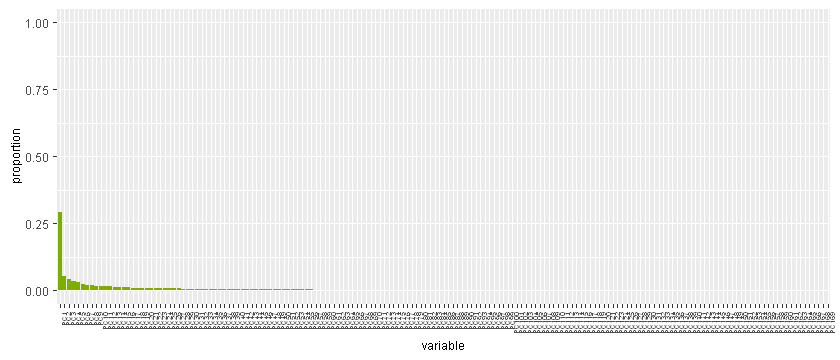

In [15]:
ggplot(scree) + ylim(0,1) +
geom_col(aes(x=factor(axis, levels=axis), y=proportion)) +
theme(axis.text.x=element_text(size=4, hjust=1, angle=90)) +
xlab("variable")

Keep the variables comprising just over 75% of the total variance.

In [16]:
scree75 = scree[c(which(scree$cum_proportion <= 0.75), (which(scree$cum_proportion > 0.75))[1]), ]
fmt(head(scree75), row.names=FALSE)

axis,standard_deviation,variance,cum_variance,proportion,cum_proportion
PC1,7.038895,49.546038,49.54604,0.2931718,0.2931718
PC2,3.012196,9.073327,58.61936,0.0536883,0.3468601
PC3,2.675560,7.158620,65.77799,0.0423587,0.3892188
PC4,2.415069,5.832559,71.61054,0.0345122,0.4237310
PC5,2.336775,5.460516,77.07106,0.0323107,0.4560418
PC6,2.051359,4.208075,81.27913,0.0248998,0.4809416


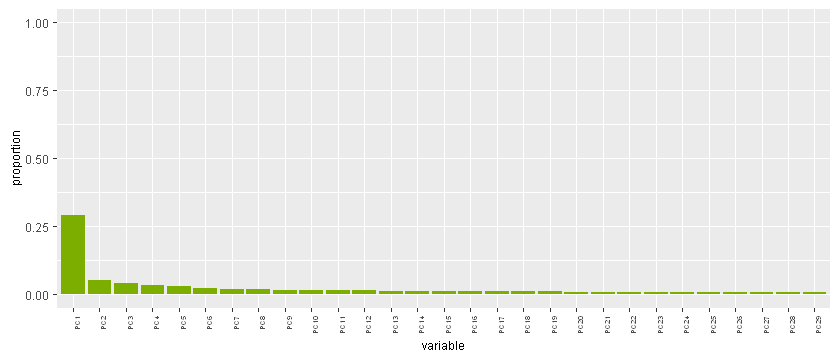

In [17]:
ggplot(scree75) + ylim(0,1) +
geom_col(aes(x=factor(axis, levels=axis), y=proportion)) +
theme(axis.text.x=element_text(size=4, hjust=1, angle=90)) +
xlab("variable")

In [18]:
data.pc75 = data.pc[, c("class", as.character(scree75$axis))]
layout(size(data.pc75), data.frame(table(data.pc75$class, dnn="class")))
head(data.pc75)

observations,variables
5000,30
class,Freq
failure,84
ok,4916


class,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29
ok,-2.5016616,1.11763285,1.46083609,0.5326031,0.28731334,1.08007234,0.30991871,-0.2264782,-0.23285126,0.63423265,0.470049849,-0.7620630,0.390828428,-0.17362332,0.479170829,0.18201219,0.31813488,-0.51560099,0.2426495555,1.04503893,0.02709185,0.18766618,0.09783017,-0.08635756,0.08071075,0.16752098,-1.02238526,-0.15607695,0.10028759
ok,0.6138081,0.57242782,0.01150911,-0.1415241,0.22496656,-0.04181799,0.19491531,0.1323332,0.29965057,-0.01241214,-0.002923239,-0.1220931,0.009003421,-0.07860466,0.182053251,0.02429613,0.03663929,-0.14120480,0.1987990462,0.24833347,-0.07393858,-0.06140221,0.21186239,-0.29690090,0.07663983,0.39135737,0.01192074,0.07713267,-0.21463090
ok,1.3116010,0.10522928,0.30725923,-0.5898392,-0.43839603,-0.04925877,0.01902651,0.1201145,0.13286054,-0.13772960,-0.414974955,0.2702396,-0.257879772,-0.24748901,-0.288619931,0.17798831,-0.12362025,-0.33377239,-0.0306500407,-0.03538915,0.16882616,-0.02267880,-0.08176841,0.21440097,-0.07550156,0.06707606,-0.25104101,-0.14388678,-0.05010384
ok,3.3915453,-0.12179429,-0.38391990,-0.3122649,-0.46340599,-0.56157680,-0.74151955,0.6139222,0.06497669,-1.56547990,-0.327885207,1.0527676,0.424897768,3.58079243,0.003459533,-0.21114968,0.53667253,-1.60446436,-0.0002430546,-0.58178598,1.99825164,0.43544736,0.30992418,0.17864045,0.38082292,-0.32186409,-0.12439293,0.19238523,0.45437218
ok,-0.3293894,-0.01173946,0.73233123,0.1947815,0.41802183,0.47376438,0.21084880,-0.2363000,-0.66549417,0.08876001,0.786559870,-0.8607165,0.156653470,-0.41139417,0.090427636,0.06553127,0.12096125,0.07645085,-0.3488739529,-0.03042796,0.06081371,0.26918689,-0.06486717,0.07109644,-0.28507821,0.10766719,0.14638493,0.10656604,0.29874186
ok,0.9384232,0.27060018,0.64892613,-0.3552778,0.05552526,0.21552088,-0.24954611,0.0202353,0.15952008,0.12471714,-0.107946567,-0.1443843,0.226293914,-0.07395265,0.262953630,0.30004412,0.00132821,-0.25568562,0.2755175629,0.32621952,-0.01405934,-0.04135678,0.43794623,0.26522843,0.24125595,-0.25109679,-0.60007318,-0.52477862,-0.32805471


Balance dataset by bootstrapping.

class,Freq
failure,84
ok,4916


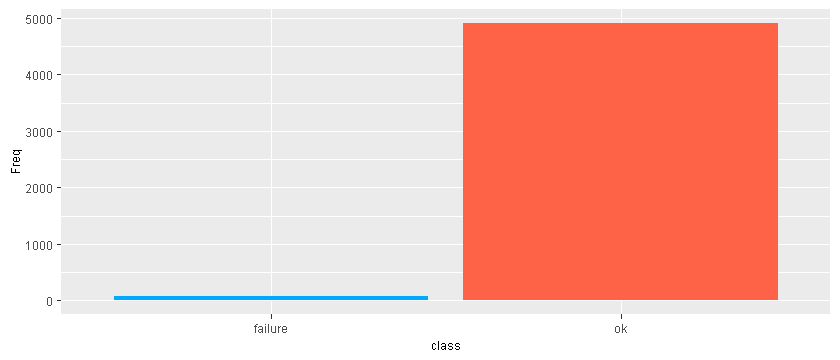

In [19]:
frequency = data.frame(table(data$class, dnn="class"))
frequency

ggplot(frequency) + geom_col(aes(x=class, y=Freq, fill=class)) + theme.no_legend

In [20]:
set.seed(0)

ok = data.pc75[data.pc75$class=="ok",]
failure = data.pc75[data.pc75$class=="failure",]

data.bal = rbind(ok, failure[sample(1:nrow(failure), nrow(ok), replace=TRUE), ])

layout(size(data.bal), data.frame(table(data.bal$class, dnn="class")))
head(data.bal)

observations,variables
9832,30
class,Freq
failure,4916
ok,4916


class,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29
ok,-2.5016616,1.11763285,1.46083609,0.5326031,0.28731334,1.08007234,0.30991871,-0.2264782,-0.23285126,0.63423265,0.470049849,-0.7620630,0.390828428,-0.17362332,0.479170829,0.18201219,0.31813488,-0.51560099,0.2426495555,1.04503893,0.02709185,0.18766618,0.09783017,-0.08635756,0.08071075,0.16752098,-1.02238526,-0.15607695,0.10028759
ok,0.6138081,0.57242782,0.01150911,-0.1415241,0.22496656,-0.04181799,0.19491531,0.1323332,0.29965057,-0.01241214,-0.002923239,-0.1220931,0.009003421,-0.07860466,0.182053251,0.02429613,0.03663929,-0.14120480,0.1987990462,0.24833347,-0.07393858,-0.06140221,0.21186239,-0.29690090,0.07663983,0.39135737,0.01192074,0.07713267,-0.21463090
ok,1.3116010,0.10522928,0.30725923,-0.5898392,-0.43839603,-0.04925877,0.01902651,0.1201145,0.13286054,-0.13772960,-0.414974955,0.2702396,-0.257879772,-0.24748901,-0.288619931,0.17798831,-0.12362025,-0.33377239,-0.0306500407,-0.03538915,0.16882616,-0.02267880,-0.08176841,0.21440097,-0.07550156,0.06707606,-0.25104101,-0.14388678,-0.05010384
ok,3.3915453,-0.12179429,-0.38391990,-0.3122649,-0.46340599,-0.56157680,-0.74151955,0.6139222,0.06497669,-1.56547990,-0.327885207,1.0527676,0.424897768,3.58079243,0.003459533,-0.21114968,0.53667253,-1.60446436,-0.0002430546,-0.58178598,1.99825164,0.43544736,0.30992418,0.17864045,0.38082292,-0.32186409,-0.12439293,0.19238523,0.45437218
ok,-0.3293894,-0.01173946,0.73233123,0.1947815,0.41802183,0.47376438,0.21084880,-0.2363000,-0.66549417,0.08876001,0.786559870,-0.8607165,0.156653470,-0.41139417,0.090427636,0.06553127,0.12096125,0.07645085,-0.3488739529,-0.03042796,0.06081371,0.26918689,-0.06486717,0.07109644,-0.28507821,0.10766719,0.14638493,0.10656604,0.29874186
ok,0.9384232,0.27060018,0.64892613,-0.3552778,0.05552526,0.21552088,-0.24954611,0.0202353,0.15952008,0.12471714,-0.107946567,-0.1443843,0.226293914,-0.07395265,0.262953630,0.30004412,0.00132821,-0.25568562,0.2755175629,0.32621952,-0.01405934,-0.04135678,0.43794623,0.26522843,0.24125595,-0.25109679,-0.60007318,-0.52477862,-0.32805471


#### Build Model

In [21]:
data.train = data.bal

In [22]:
set.seed(0)
model = svm(class ~ ., data.train, kernel="radial", gamma=0.1, cost=0.1, scale=TRUE, probability=TRUE) # may take about 30 seconds
model


Call:
svm(formula = class ~ ., data = data.train, kernel = "radial", gamma = 0.1, 
    cost = 0.1, probability = TRUE, scale = TRUE)


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  0.1 

Number of Support Vectors:  1399


####  Check Insample Performance & Business Value, Vary Cutoff

In [23]:
data.val = data.train

In [24]:
prob = attr(predict(model, data.val, probability=TRUE), "probabilities")
fmt(head(prob), title="prob")

ok,failure
0.9772441,0.0227559
0.9775304,0.0224696
0.9785830,0.0214170
0.9308987,0.0691013
0.9804628,0.0195372
0.9795911,0.0204089


In [25]:
cutoff = 0.90
class.predicted = as.class(prob, "failure", cutoff)
CM = confusionMatrix(class.predicted, data.val$class)$table
cm = CM / sum(CM)

layout(fmt.cm(cm, paste0("cm @ cutoff=",cutoff)),
       fmt(data.frame(tpr=cm[1,1]/sum(cm[,1]), tnr=cm[2,2]/sum(cm[,2]), accuracy=cm[1,1]+cm[2,2]), "performance metrics"))

,failure,ok
failure,0.464402,0.0087469
ok,0.035598,0.4912531
tpr,tnr,accuracy
0.9288039,0.9825061,0.955655


In [26]:
count.unnecessary_check =  (cm["failure","ok"] / sum(cm[,"ok"])) * pop.ok
count.missed_failure = (cm["ok","failure"] / sum(cm[,"failure"])) * pop.failure
cost = cost.unnecessary_check*count.unnecessary_check + cost.missed_failure*count.missed_failure
cost

[1] 459194.5

Cutoff = 0.50:

In [27]:
cutoff = 0.50
class.predicted = as.class(prob, "failure", cutoff)
CM = confusionMatrix(class.predicted, data.val$class)$table
cm = CM / sum(CM)

layout(fmt.cm(cm, paste0("cm @ cutoff=",cutoff)),
       fmt(data.frame(tpr=cm[1,1]/sum(cm[,1]), tnr=cm[2,2]/sum(cm[,2]), accuracy=cm[1,1]+cm[2,2]), "performance metrics"))

,failure,ok
failure,0.4823027,0.0181041
ok,0.0176973,0.4818959
tpr,tnr,accuracy
0.9646054,0.9637917,0.9641985


In [28]:
count.unnecessary_check =  (cm["failure","ok"] / sum(cm[,"ok"])) * pop.ok
count.missed_failure = (cm["ok","failure"] / sum(cm[,"failure"])) * pop.failure
cost = cost.unnecessary_check*count.unnecessary_check + cost.missed_failure*count.missed_failure
cost

[1] 390602.1

Cutoff = 0.10:

In [29]:
cutoff = 0.10
class.predicted = as.class(prob, "failure", cutoff)
CM = confusionMatrix(class.predicted, data.val$class)$table
cm = CM / sum(CM)

layout(fmt.cm(cm, paste0("cm @ cutoff=",cutoff)),
       fmt(data.frame(tpr=cm[1,1]/sum(cm[,1]), tnr=cm[2,2]/sum(cm[,2]), accuracy=cm[1,1]+cm[2,2]), "performance metrics"))

,failure,ok
failure,0.4878967,0.0326485
ok,0.0121033,0.4673515
tpr,tnr,accuracy
0.9757933,0.934703,0.9552482


In [30]:
count.unnecessary_check =  (cm["failure","ok"] / sum(cm[,"ok"])) * pop.ok
count.missed_failure = (cm["ok","failure"] / sum(cm[,"failure"])) * pop.failure
cost = cost.unnecessary_check*count.unnecessary_check + cost.missed_failure*count.missed_failure
cost

[1] 506285.6

## Analysis II

### Retrieve New Data

In [31]:
new = read.csv("Scania new.csv", na.strings="na")
layout(size(new), data.frame(table(new$class, dnn="class")))
head(new)

observations,variables
16000,171
class,Freq
neg,15625
pos,375


class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,...,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
neg,60,0,20,12,0,0,0,0,0,2682,4736,3862,1846,0,0,0,3976,0,0,0,1520,2374,11516,9480,111258,470,0,0,0,0,58,26,0,0,0,0,...,112,0,0,0,0,0,0,0,0,340,0,0,1100,574,232,66,780,882,0,4,0,0,0,465.50,90,7502,3156,1098,138,412,654,78,88,0,0,0,0
neg,82,0,68,40,0,0,0,0,0,0,748,12594,3636,0,0,0,5244,0,60,0,0,0,23174,18166,23686,1270,0,0,0,0,12,82,0,0,0,0,...,40,0,0,0,0,0,0,0,0,352,0,0,3996,584,200,62,37580,3756,6368,36,0,0,0,2.86,102,10040,3310,1068,276,1620,116,86,462,0,0,0,0
neg,66002,2,212,112,0,0,0,0,0,199486,1358536,1952422,452706,25130,520,0,1891670,0,0,0,77898,110548,3605894,3291610,959756,286536,0,0,0,0,106,340,0,0,0,0,...,692,0,0,0,0,0,0,0,0,25278,9438,2504,10262714,1278664,109700,19072,9520,4902,4434614,70900,0,0,26002880,2057.84,2158,396312,538136,495076,380368,440134,269556,1315022,153680,516,0,0,0
neg,59816,NA,1010,936,0,0,0,0,0,0,123922,984314,1680050,1135268,92606,14038,1772828,0,0,0,1116,2372,3546760,3053176,652616,423374,0,0,7274,0,1622,432,0,0,0,0,...,414,0,0,60,38710,0,0,0,0,27740,33354,6330,0,0,133542,21290,2718360,435370,0,0,0,0,1179900,1541.32,1678,659550,691580,540820,243270,483302,485332,431376,210074,281662,3232,0,0
neg,1814,NA,156,140,0,0,0,0,0,0,72,17926,82834,3114,0,0,48978,0,0,0,0,0,97146,89920,12932,5092,0,0,0,0,102,50,0,0,0,0,...,36,0,0,0,0,0,0,0,0,538,360,142,0,0,1822,344,2140,394,13664,110,0,0,813740,113.86,52,10216,9958,7646,4144,18466,49782,3176,482,76,0,0,0
neg,174,NA,26,24,0,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,7396,0,134,0,0,0,22666,19998,14550,788,0,0,0,0,40,124,NA,NA,NA,NA,...,74,0,0,0,0,0,0,0,0,230,0,0,6716,2274,610,126,920,242,8862,20,0,0,0,131.70,56,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,0


### Business Parameters

In [32]:
pop = nrow(new)
pop.ok = nrow(new[new$class=="neg",])
pop.failure = nrow(new[new$class=="pos",])

data.frame(pop.ok, pop.failure, cost.unnecessary_check, cost.missed_failure)

pop.ok,pop.failure,cost.unnecessary_check,cost.missed_failure
15625,375,100,5000


### Baseline

In [33]:
cost.check_all = pop * cost.unnecessary_check
cost.check_none = pop.failure * cost.missed_failure
data.frame(cost.check_all, cost.check_none)

cost.check_all,cost.check_none
1600000,1875000


### Prepare New Data

Rename classes.

In [34]:
new$class = factor(new$class, levels=c("pos","neg"), labels=c("failure","ok"))
layout(size(new), data.frame(table(new$class, dnn="class")))
head(new)

observations,variables
16000,171
class,Freq
failure,375
ok,15625


class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,...,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
ok,60,0,20,12,0,0,0,0,0,2682,4736,3862,1846,0,0,0,3976,0,0,0,1520,2374,11516,9480,111258,470,0,0,0,0,58,26,0,0,0,0,...,112,0,0,0,0,0,0,0,0,340,0,0,1100,574,232,66,780,882,0,4,0,0,0,465.50,90,7502,3156,1098,138,412,654,78,88,0,0,0,0
ok,82,0,68,40,0,0,0,0,0,0,748,12594,3636,0,0,0,5244,0,60,0,0,0,23174,18166,23686,1270,0,0,0,0,12,82,0,0,0,0,...,40,0,0,0,0,0,0,0,0,352,0,0,3996,584,200,62,37580,3756,6368,36,0,0,0,2.86,102,10040,3310,1068,276,1620,116,86,462,0,0,0,0
ok,66002,2,212,112,0,0,0,0,0,199486,1358536,1952422,452706,25130,520,0,1891670,0,0,0,77898,110548,3605894,3291610,959756,286536,0,0,0,0,106,340,0,0,0,0,...,692,0,0,0,0,0,0,0,0,25278,9438,2504,10262714,1278664,109700,19072,9520,4902,4434614,70900,0,0,26002880,2057.84,2158,396312,538136,495076,380368,440134,269556,1315022,153680,516,0,0,0
ok,59816,NA,1010,936,0,0,0,0,0,0,123922,984314,1680050,1135268,92606,14038,1772828,0,0,0,1116,2372,3546760,3053176,652616,423374,0,0,7274,0,1622,432,0,0,0,0,...,414,0,0,60,38710,0,0,0,0,27740,33354,6330,0,0,133542,21290,2718360,435370,0,0,0,0,1179900,1541.32,1678,659550,691580,540820,243270,483302,485332,431376,210074,281662,3232,0,0
ok,1814,NA,156,140,0,0,0,0,0,0,72,17926,82834,3114,0,0,48978,0,0,0,0,0,97146,89920,12932,5092,0,0,0,0,102,50,0,0,0,0,...,36,0,0,0,0,0,0,0,0,538,360,142,0,0,1822,344,2140,394,13664,110,0,0,813740,113.86,52,10216,9958,7646,4144,18466,49782,3176,482,76,0,0,0
ok,174,NA,26,24,0,0,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,7396,0,134,0,0,0,22666,19998,14550,788,0,0,0,0,40,124,NA,NA,NA,NA,...,74,0,0,0,0,0,0,0,0,230,0,0,6716,2274,610,126,920,242,8862,20,0,0,0,131.70,56,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,0,0


Impute missing values with previously calculated column means.

In [35]:
new.imputed = cbind(class=new$class, put_impute(new[,-1], imputation_values))
layout(size(new.imputed), data.frame(table(new.imputed$class, dnn="class")))
head(new.imputed)

observations,variables
16000,171
class,Freq
failure,375
ok,15625


class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,...,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
ok,60,0.0000000,20,12,0,0,0.0000,0.0000,0.000,2682.0,4736.0,3862,1846,0,0.00,0.000,3976,0,0,0,1520,2374,11516,9480,111258,470,0,0,0,0,58,26,0.000,0.000,0.000,0.000,...,112,0,0,0,0,0,0,0,0,340,0,0,1100,574,232,66,780,882,0,4,0,0,0,465.50,90,7502,3156.0,1098.0,138.0,412,654.0,78.0,88.0,0.0,0.000,0,0
ok,82,0.0000000,68,40,0,0,0.0000,0.0000,0.000,0.0,748.0,12594,3636,0,0.00,0.000,5244,0,60,0,0,0,23174,18166,23686,1270,0,0,0,0,12,82,0.000,0.000,0.000,0.000,...,40,0,0,0,0,0,0,0,0,352,0,0,3996,584,200,62,37580,3756,6368,36,0,0,0,2.86,102,10040,3310.0,1068.0,276.0,1620,116.0,86.0,462.0,0.0,0.000,0,0
ok,66002,2.0000000,212,112,0,0,0.0000,0.0000,0.000,199486.0,1358536.0,1952422,452706,25130,520.00,0.000,1891670,0,0,0,77898,110548,3605894,3291610,959756,286536,0,0,0,0,106,340,0.000,0.000,0.000,0.000,...,692,0,0,0,0,0,0,0,0,25278,9438,2504,10262714,1278664,109700,19072,9520,4902,4434614,70900,0,0,26002880,2057.84,2158,396312,538136.0,495076.0,380368.0,440134,269556.0,1315022.0,153680.0,516.0,0.000,0,0
ok,59816,0.5747538,1010,936,0,0,0.0000,0.0000,0.000,0.0,123922.0,984314,1680050,1135268,92606.00,14038.000,1772828,0,0,0,1116,2372,3546760,3053176,652616,423374,0,0,7274,0,1622,432,0.000,0.000,0.000,0.000,...,414,0,0,60,38710,0,0,0,0,27740,33354,6330,0,0,133542,21290,2718360,435370,0,0,0,0,1179900,1541.32,1678,659550,691580.0,540820.0,243270.0,483302,485332.0,431376.0,210074.0,281662.0,3232.000,0,0
ok,1814,0.5747538,156,140,0,0,0.0000,0.0000,0.000,0.0,72.0,17926,82834,3114,0.00,0.000,48978,0,0,0,0,0,97146,89920,12932,5092,0,0,0,0,102,50,0.000,0.000,0.000,0.000,...,36,0,0,0,0,0,0,0,0,538,360,142,0,0,1822,344,2140,394,13664,110,0,0,813740,113.86,52,10216,9958.0,7646.0,4144.0,18466,49782.0,3176.0,482.0,76.0,0.000,0,0
ok,174,0.5747538,26,24,0,0,834.0948,864.6159,9264.315,74510.5,374906.9,1041974,1702567,532930,38820.76,5115.463,7396,0,134,0,0,0,22666,19998,14550,788,0,0,0,0,40,124,4133.257,1478.234,5813.426,5810.486,...,74,0,0,0,0,0,0,0,0,230,0,0,6716,2274,610,126,920,242,8862,20,0,0,0,131.70,56,729756,813874.3,442367.2,208372.9,438828,388357.4,311602.2,295832.9,134991.8,7762.441,0,0


Remove columns that were previously removed.

In [36]:
new.var = new.imputed[, c(TRUE, keep_vars)]
layout(size(new.var), data.frame(table(new.var$class, dnn="class")))
head(new.var)

observations,variables
16000,170
class,Freq
failure,375
ok,15625


class,aa_000,ab_000,ac_000,ad_000,ae_000,af_000,ag_000,ag_001,ag_002,ag_003,ag_004,ag_005,ag_006,ag_007,ag_008,ag_009,ah_000,ai_000,aj_000,ak_000,al_000,am_0,an_000,ao_000,ap_000,aq_000,ar_000,as_000,at_000,au_000,av_000,ax_000,ay_000,ay_001,ay_002,ay_003,...,de_000,df_000,dg_000,dh_000,di_000,dj_000,dk_000,dl_000,dm_000,dn_000,do_000,dp_000,dq_000,dr_000,ds_000,dt_000,du_000,dv_000,dx_000,dy_000,dz_000,ea_000,eb_000,ec_00,ed_000,ee_000,ee_001,ee_002,ee_003,ee_004,ee_005,ee_006,ee_007,ee_008,ee_009,ef_000,eg_000
ok,60,0.0000000,20,12,0,0,0.0000,0.0000,0.000,2682.0,4736.0,3862,1846,0,0.00,0.000,3976,0,0,0,1520,2374,11516,9480,111258,470,0,0,0,0,58,26,0.000,0.000,0.000,0.000,...,112,0,0,0,0,0,0,0,0,340,0,0,1100,574,232,66,780,882,0,4,0,0,0,465.50,90,7502,3156.0,1098.0,138.0,412,654.0,78.0,88.0,0.0,0.000,0,0
ok,82,0.0000000,68,40,0,0,0.0000,0.0000,0.000,0.0,748.0,12594,3636,0,0.00,0.000,5244,0,60,0,0,0,23174,18166,23686,1270,0,0,0,0,12,82,0.000,0.000,0.000,0.000,...,40,0,0,0,0,0,0,0,0,352,0,0,3996,584,200,62,37580,3756,6368,36,0,0,0,2.86,102,10040,3310.0,1068.0,276.0,1620,116.0,86.0,462.0,0.0,0.000,0,0
ok,66002,2.0000000,212,112,0,0,0.0000,0.0000,0.000,199486.0,1358536.0,1952422,452706,25130,520.00,0.000,1891670,0,0,0,77898,110548,3605894,3291610,959756,286536,0,0,0,0,106,340,0.000,0.000,0.000,0.000,...,692,0,0,0,0,0,0,0,0,25278,9438,2504,10262714,1278664,109700,19072,9520,4902,4434614,70900,0,0,26002880,2057.84,2158,396312,538136.0,495076.0,380368.0,440134,269556.0,1315022.0,153680.0,516.0,0.000,0,0
ok,59816,0.5747538,1010,936,0,0,0.0000,0.0000,0.000,0.0,123922.0,984314,1680050,1135268,92606.00,14038.000,1772828,0,0,0,1116,2372,3546760,3053176,652616,423374,0,0,7274,0,1622,432,0.000,0.000,0.000,0.000,...,414,0,0,60,38710,0,0,0,0,27740,33354,6330,0,0,133542,21290,2718360,435370,0,0,0,0,1179900,1541.32,1678,659550,691580.0,540820.0,243270.0,483302,485332.0,431376.0,210074.0,281662.0,3232.000,0,0
ok,1814,0.5747538,156,140,0,0,0.0000,0.0000,0.000,0.0,72.0,17926,82834,3114,0.00,0.000,48978,0,0,0,0,0,97146,89920,12932,5092,0,0,0,0,102,50,0.000,0.000,0.000,0.000,...,36,0,0,0,0,0,0,0,0,538,360,142,0,0,1822,344,2140,394,13664,110,0,0,813740,113.86,52,10216,9958.0,7646.0,4144.0,18466,49782.0,3176.0,482.0,76.0,0.000,0,0
ok,174,0.5747538,26,24,0,0,834.0948,864.6159,9264.315,74510.5,374906.9,1041974,1702567,532930,38820.76,5115.463,7396,0,134,0,0,0,22666,19998,14550,788,0,0,0,0,40,124,4133.257,1478.234,5813.426,5810.486,...,74,0,0,0,0,0,0,0,0,230,0,0,6716,2274,610,126,920,242,8862,20,0,0,0,131.70,56,729756,813874.3,442367.2,208372.9,438828,388357.4,311602.2,295832.9,134991.8,7762.441,0,0


Represent as principal components using previously calculated weight matrix.

In [37]:
new.pc = cbind(class=new.var$class, as.data.frame(predict(pc, newdata=new.var[,-1])))
layout(size(new.pc), data.frame(table(new.pc$class, dnn="class")))
head(new.pc)

observations,variables
16000,170
class,Freq
failure,375
ok,15625


class,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,...,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149,PC150,PC151,PC152,PC153,PC154,PC155,PC156,PC157,PC158,PC159,PC160,PC161,PC162,PC163,PC164,PC165,PC166,PC167,PC168,PC169
ok,3.2846533,0.04117724,-0.3844503,-0.3831980,-0.47252033,-0.63877968,-0.2462275,0.03462402,0.3127344,-0.03929556,-0.5583654,0.4630843,-0.03622493,0.05924508,0.03587917,-0.054501258,0.11484622,0.1961605972,-0.003768851,0.07079745,0.17852898,-0.06655334,-0.10844149,-0.06442755,0.12641246,-0.041836612,0.103883013,0.19226040,-0.030619602,0.03555152,-0.10025977,-0.3527851,0.064537536,0.12682570,0.009542645,0.33157702,...,0.003226216,-0.019818699,0.018565828,-0.018443298,0.0248964076,0.008303164,0.0543107498,0.0244696161,0.015625731,-0.006017712,-0.007811671,0.0005904184,-0.004028945,-0.003743585,0.003588536,-0.008088305,0.008442686,0.0048319823,-0.007679970,-0.001262058,0.0078429623,-0.004560532,-0.009639770,0.000549379,0.004645736,0.00003887275,-0.0011248619,0.0004920807,-0.0007012909,0.0004061507,0.000049203611,0.0000009293435,-0.000000037642490,-0.0000002282730,0.00000009030663,-0.000000021499380,-0.0000000033591473
ok,3.3711718,0.04548392,-0.4231515,-0.4875297,-0.51276984,-0.63289545,-0.3279398,0.04259542,0.5645463,-0.11550575,-0.9435231,0.8157261,-0.17087167,0.07783232,-0.28053373,0.037808808,-0.07132182,-0.0002241936,0.140730454,-0.02349148,0.17072357,-0.08690575,-0.05087217,0.09260194,0.10767202,-0.072970279,0.001499529,0.09946280,-0.080180640,0.07477690,-0.05325206,-0.2246731,0.082141428,0.13052316,-0.046971105,0.34541956,...,0.012841195,0.006159748,-0.003570585,0.014955926,0.0003090615,0.008218125,-0.0234909024,-0.0016598360,0.007687971,0.016851815,0.006697857,0.0075567150,-0.004086410,-0.006137092,-0.001059644,0.004511802,0.001932542,0.0003244088,-0.008348290,0.004322326,-0.0061443874,-0.001548808,-0.003763016,-0.001954762,0.001649129,-0.00051694419,-0.0009757711,0.0006571803,-0.0001872243,-0.0003489713,-0.000002649027,0.0000003678181,-0.000000039516270,0.0000001004798,0.00000005687087,-0.000000009992495,-0.0000000003572373
ok,-1.1853445,-2.10371005,0.3212271,1.9469381,0.05143541,0.40026737,-1.0912377,2.54334536,-0.9445667,0.43375260,0.4909647,-1.3757335,-0.37418019,-0.08699712,0.88969604,0.118390680,0.09288621,1.0334893547,-1.147188699,0.35784865,-0.32919144,-0.05179968,-0.57842225,-1.25945685,-0.29798165,0.547137367,0.127261712,-0.09486704,-0.568383044,-0.07990147,-0.32140970,-1.0503161,-0.000473039,0.31190996,0.612302136,-0.34333138,...,-0.048454361,-0.130743646,-0.092290631,0.062444714,0.0522312803,-0.009911300,-0.2971582102,0.1467601712,0.029824384,0.093065849,0.049080126,0.1121244235,-0.067580617,-0.217344631,-0.030911812,0.035112384,-0.077043997,-0.0092802285,-0.028868448,0.044241251,-0.0629820302,0.051844515,0.064149492,0.006229493,-0.009686531,-0.01460316752,-0.0017475688,-0.0003882583,-0.0011740916,-0.0059851303,-0.000078479583,0.0000025789196,-0.000000352416587,-0.0000008401261,0.00000054685493,-0.000000074745105,0.0000000138026841
ok,-0.2145577,0.51107401,0.8112588,0.1708617,-0.48846625,0.45910960,0.5373236,-0.10370124,-0.3190726,0.02153808,0.4518827,-0.6568288,-0.16436775,-0.24987354,0.07139075,0.007732008,-0.08098026,-0.0189061728,-0.126639751,-0.21527262,-0.06272764,0.26364642,0.07786134,0.30664968,0.04824543,-0.327121514,0.604905426,-0.10428420,-0.210478740,0.09474521,-0.12632484,0.2720930,0.617533795,-0.01497050,-0.573232778,-0.38096551,...,0.027876048,-0.107527633,-0.027046655,-0.024454222,-0.0365486459,0.028575486,-0.0005717434,-0.0005895869,-0.043891452,-0.056631690,0.173254604,-0.0751043642,-0.057128954,0.065982258,-0.058995310,0.045295696,-0.021233998,-0.0106102556,-0.005738640,-0.038923878,-0.0007140413,0.011543938,-0.009059976,-0.013927385,-0.015138926,-0.00853891604,-0.0010226479,0.0005368313,-0.00226

Keep the variables that previously comprised just over 75% of total variance.

In [38]:
new.pc75 = new.pc[, c("class", as.character(scree75$axis))]
layout(size(new.pc75), data.frame(table(new.pc75$class, dnn="class")))
head(new.pc75)

observations,variables
16000,30
class,Freq
failure,375
ok,15625


class,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29
ok,3.2846533,0.04117724,-0.3844503,-0.3831980,-0.47252033,-0.63877968,-0.2462275,0.03462402,0.3127344,-0.03929556,-0.5583654,0.4630843,-0.03622493,0.05924508,0.03587917,-0.054501258,0.11484622,0.1961605972,-0.003768851,0.07079745,0.17852898,-0.06655334,-0.10844149,-0.06442755,0.12641246,-0.041836612,0.103883013,0.19226040,-0.030619602
ok,3.3711718,0.04548392,-0.4231515,-0.4875297,-0.51276984,-0.63289545,-0.3279398,0.04259542,0.5645463,-0.11550575,-0.9435231,0.8157261,-0.17087167,0.07783232,-0.28053373,0.037808808,-0.07132182,-0.0002241936,0.140730454,-0.02349148,0.17072357,-0.08690575,-0.05087217,0.09260194,0.10767202,-0.072970279,0.001499529,0.09946280,-0.080180640
ok,-1.1853445,-2.10371005,0.3212271,1.9469381,0.05143541,0.40026737,-1.0912377,2.54334536,-0.9445667,0.43375260,0.4909647,-1.3757335,-0.37418019,-0.08699712,0.88969604,0.118390680,0.09288621,1.0334893547,-1.147188699,0.35784865,-0.32919144,-0.05179968,-0.57842225,-1.25945685,-0.29798165,0.547137367,0.127261712,-0.09486704,-0.568383044
ok,-0.2145577,0.51107401,0.8112588,0.1708617,-0.48846625,0.45910960,0.5373236,-0.10370124,-0.3190726,0.02153808,0.4518827,-0.6568288,-0.16436775,-0.24987354,0.07139075,0.007732008,-0.08098026,-0.0189061728,-0.126639751,-0.21527262,-0.06272764,0.26364642,0.07786134,0.30664968,0.04824543,-0.327121514,0.604905426,-0.10428420,-0.210478740
ok,3.3281343,0.01072758,-0.3976069,-0.4503783,-0.49259660,-0.56530261,-0.2734102,0.01817781,0.5042903,-0.12313589,-0.8442709,0.7579416,-0.16498080,0.07065457,-0.26543530,0.038978006,-0.05284648,-0.0494508969,0.071438662,-0.04561070,0.08675870,-0.05819271,-0.03177749,0.04097503,0.06406058,-0.001819134,0.067872150,0.01917599,-0.011820675
ok,1.8402705,0.53199053,-0.7787997,-0.9272345,-1.01833336,0.01149457,-0.6696298,0.35036217,0.3951782,-0.25538791,-0.8861976,0.7701252,-0.47771579,-0.08406597,-0.39519851,-0.057730967,-0.11614902,-0.1720437219,0.164635010,-0.29816217,0.12154247,-0.11073350,-0.17475756,0.19024198,0.03797304,-0.244698446,0.170249605,0.08941154,0.002812037


### Check Test Performance & Business Value, Vary Cutoff

In [39]:
data.test = new.pc75

In [40]:
prob = attr(predict(model, data.test, probability=TRUE), "probabilities")
fmt(head(prob), title="prob")

ok,failure
0.9737555,0.0262445
0.9705665,0.0294335
0.9738790,0.0261210
0.9873016,0.0126984
0.9731396,0.0268604
0.9783250,0.0216750


In [41]:
cutoff = 0.90
class.predicted = as.class(prob, "failure", cutoff)
CM = confusionMatrix(class.predicted, data.test$class)$table
cm = CM / sum(CM)
fmt.cm(cm, paste0("cm @ cutoff=",cutoff))

accuracy90 = cm[1,1]+cm[2,2]
accuracy90

,failure,ok
failure,0.0199375,0.0172500
ok,0.0035000,0.9593125


[1] 0.97925

In [42]:
count.unnecessary_check =  (cm["failure","ok"] / sum(cm[,"ok"])) * pop.ok
count.missed_failure = (cm["ok","failure"] / sum(cm[,"failure"])) * pop.failure
cost90 = cost.unnecessary_check*count.unnecessary_check + cost.missed_failure*count.missed_failure
cost90

[1] 307600

In [43]:
cutoff = 0.50
class.predicted = as.class(prob, "failure", cutoff)
CM = confusionMatrix(class.predicted, data.test$class)$table
cm = CM / sum(CM)
fmt.cm(cm, paste0("cm @ cutoff=",cutoff))

accuracy50 = cm[1,1]+cm[2,2]
accuracy50

,failure,ok
failure,0.0217500,0.0328125
ok,0.0016875,0.9437500


[1] 0.9655

In [44]:
count.unnecessary_check =  (cm["failure","ok"] / sum(cm[,"ok"])) * pop.ok
count.missed_failure = (cm["ok","failure"] / sum(cm[,"failure"])) * pop.failure
cost50 = cost.unnecessary_check*count.unnecessary_check + cost.missed_failure*count.missed_failure
cost50

[1] 187500

In [45]:
cutoff = 0.25
class.predicted = as.class(prob, "failure", cutoff)
CM = confusionMatrix(class.predicted, data.test$class)$table
cm = CM / sum(CM)
fmt.cm(cm, paste0("cm @ cutoff=",cutoff))

accuracy25 = cm[1,1]+cm[2,2]
accuracy25

,failure,ok
failure,0.0225625,0.0431875
ok,0.0008750,0.9333750


[1] 0.9559375

In [46]:
count.unnecessary_check =  (cm["failure","ok"] / sum(cm[,"ok"])) * pop.ok
count.missed_failure = (cm["ok","failure"] / sum(cm[,"failure"])) * pop.failure
cost25 = cost.unnecessary_check*count.unnecessary_check + cost.missed_failure*count.missed_failure
cost25

[1] 139100

### Compare Cutoffs

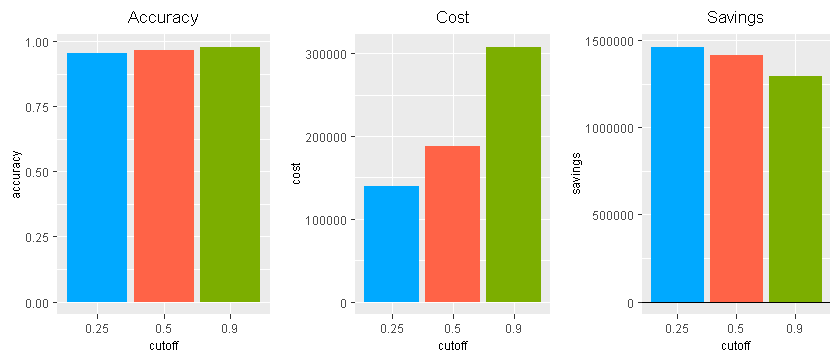

In [47]:
result = data.frame(cutoff=factor(c(0.90, 0.50, 0.25)),
                    accuracy=c(accuracy90, accuracy50, accuracy25),
                    cost=c(cost90, cost50, cost25))

p1 = ggplot(result) + ggtitle("Accuracy") +
     geom_col(aes(x=cutoff, y=accuracy, fill=cutoff)) + theme.no_legend

p2 = ggplot(result) + ggtitle("Cost") +
     geom_col(aes(x=cutoff, y=cost, fill=cutoff)) + theme.no_legend

p3 = ggplot(result) + ggtitle("Savings") +
     geom_col(aes(x=cutoff, y=cost.check_all-cost, fill=cutoff)) +
     geom_hline(yintercept=0) +
     ylab("savings") + theme.no_legend

grid.arrange(p1, p2, p3, nrow=1)

## Further Reading

* https://www.kaggle.com/uciml/aps-failure-at-scania-trucks-data-set
* https://www.r-project.org/conferences/useR-2013/Tutorials/kuhn/user_caret_2up.pdf

<font size=1;>
<p style="text-align: left;">
Copyright (c) Berkeley Data Analytics Group, LLC
<span style="float: right;">
Document revised March 23, 2020
</span>
</p>
</font>